In [2]:
from sodapy import Socrata
from peewee import *
from geopy.distance import vincenty
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
from datetime import datetime
import shelve as sh
import csv
from Model import *

# Geometry tools
import json
import shapely
from shapely.geometry import mapping, shape
from shapely.geometry import Polygon
from shapely.wkt import dumps, loads
from descartes import PolygonPatch

import dglim

%matplotlib inline

### Load datasets

In [3]:
master_df = dglim.loadData('Master Dataset')

DB_path = "../../Shelve_Dbs/Active_Business_NB_Db/DGLIM_Data_Shelve.db"
data_path = '../City_Data/BusinessesWithEndDateAndLifespan/'
act_bus_df = pd.read_excel("../City_Data/DGLIM_survey_data/city of Gainesville active businesses dataset with uniqueid.xlsx")
survey_df = pd.read_excel("../City_Data/DGLIM_survey_data/DGLIM_data_final_111417.xlsx")

In [4]:
master_df[:1]

,DGLIM ID,Name,Business Type,NAICS Type,Address,Start Date,Finished Survey,Number of Employees,Successfulness,Revenue in 2016,...,Investment in 2017,GRU ID,Tract,Block,Tract-Block,Latitude,Longitude,Crimes Within 500m,DGLIM ID.1,Distance to Bus Stop
DGLIM ID,,,,,,,,,,,,,,,,,,,,,
16,16,34TH STREET SALON,BEAUTY PARLOR,Other Services,"4908 NW 34TH BLVD, #13",2006-12-28,1,0,NaN,23000,...,900,34265.0,NaN,NaN,NaN,29.699568,-82.370989,338,16,110.521226


## Retreive Block IDs and Census Tracts for Businesses

### Build Input CSV from Addresses

In [5]:
geo_address_input_df = master_df.filter(['DGLIM ID'], axis=1)

# We have to remove commas before exporting a CSV file
# Let's get rid of "APT", "SUITE", etc. while we're at it
geo_address_input_df['Street'] = master_df['Address'].apply(lambda x : x.split(',')[0])
geo_address_input_df['City'] = 'Gainesville'
geo_address_input_df['State'] = 'FL'
geo_address_input_df['ZIP'] = ''

geo_address_input_df.head()

,DGLIM ID,Street,City,State,ZIP
DGLIM ID,,,,,
16,16,4908 NW 34TH BLVD,Gainesville,FL,
17,17,978 SW 2ND AVE,Gainesville,FL,
24,24,4881 NW 8TH AVE,Gainesville,FL,
25,25,200 NE 1ST ST,Gainesville,FL,
38,38,4128 NW 13TH ST,Gainesville,FL,


In [1]:
geo_address_input_df.to_csv(
    path_or_buf = "../CSV Generated Data/Census Lookup/addresses.csv",
    header = False,
    index = False)

NameError: name 'geo_address_input_df' is not defined

*** Fetch geography data manually from https://geocoding.geo.census.gov/geocoder/geographies/addressbatch?form ***

*** Documentation at https://www.census.gov/geo/maps-data/data/geocoder.html ***

``` curl --form addressFile=@addresses.csv --form benchmark=Public_AR_Current --form vintage=Current_Current https://geocoding.geo.census.gov/geocoder/geographies/addressbatch --output geocode_results.csv ```

### Build Input CSV from Coordinates

In [6]:
geo_coord_input_df = master_df.filter(['DGLIM ID', 'Latitude', 'Longitude'], axis=1).dropna()

geo_coord_input_df[:1]

,DGLIM ID,Latitude,Longitude
DGLIM ID,,,
16,16,29.699568,-82.370989


In [7]:
geo_coord_input_df.to_csv(
    path_or_buf = "../CSV Generated Data/Census Lookup/coordinates.csv",
    header = False,
    index = False)

*** Never mind, this doesn't seem to be supported for batch processes ***

### Get Results

In [8]:
geocode_df = pd.read_csv(
    '../CSV Generated Data/Census Lookup/geocode_results.csv',
    names=['DGLIM ID', 'Input Address', 'Match', 'Match Type', 'Output Address', 'Coordinates', 'Something', 'Line Side', 'State Code', 'County Code', 'Tract Code', 'Block Code'],
    header=None,
    index_col=0)

geocode_df['DGLIM ID'] = geocode_df.index
geocode_df['Tract Code'] = geocode_df['Tract Code'].apply(lambda x: 0 if np.isnan(x) else int(x))
geocode_df['Block Code'] = geocode_df['Block Code'].apply(lambda x: 0 if np.isnan(x) else int(x))
geocode_df

,Input Address,Match,Match Type,Output Address,Coordinates,Something,Line Side,State Code,County Code,Tract Code,Block Code,DGLIM ID
DGLIM ID,,,,,,,,,,,,
6873,"4340 NEWBERRY RD, Gainesville, FL,",Match,Exact,"4340 NEWBERRY RD, GAINESVILLE, FL, 32607","-82.38842,29.655184",6848043.0,R,12.0,1.0,1603,1030,6873
6874,"OUT OF STATE, Gainesville, FL,",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6874
6871,"OUT OF STATE, Gainesville, FL,",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6871
6872,"MOBILE ONLY, Gainesville, FL,",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6872
6870,"OUT OF STATE, Gainesville, FL,",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6870
531,"4131 NW 6TH ST, Gainesville, FL,",Match,Exact,"4131 NW 6TH ST, GAINESVILLE, FL, 32609","-82.33219,29.69104",627266526.0,R,12.0,1.0,302,2005,531
530,"3501 SW 2ND AVE, Gainesville, FL,",Match,Exact,"3501 SW 2 AVE, GAINESVILLE, FL, 32607","-82.37528,29.650604",6805164.0,L,12.0,1.0,1604,1000,530
2951,"6791 W NEWBERRY RD, Gainesville, FL,",Match,Exact,"6791 W NEWBERRY RD, GAINESVILLE, FL, 32605","-82.41732,29.659536",638637340.0,R,12.0,1.0,1604,4001,2951
6869,"VARIOUS, Gainesville, FL,",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6869


*** Rearrange ***

In [9]:
def splitCoordinates(coord):
    if type(coord) is str:
        splitString = coord.split(',')
        if len(splitString) is 2:
            return [float(x) for x in splitString]
        else:
            return [np.nan, np.nan]
    else:
        return [np.nan, np.nan]

In [10]:
bus_blocks_df = pd.DataFrame(columns=['DGLIM ID', 'Tract', 'Block Group', 'Block ID', 'Latitude', 'Longitude'])
bus_blocks_df['DGLIM ID'] = geocode_df['DGLIM ID']
bus_blocks_df['Tract'] = geocode_df['Tract Code'].apply(lambda x: '' if (x == 0 or not np.isfinite(x)) else str(x))
bus_blocks_df['Block ID'] = geocode_df['Block Code'].apply(lambda x: '' if (x == 0 or not np.isfinite(x)) else str(x))
bus_blocks_df['Block Group'] = bus_blocks_df['Block ID'].apply(lambda x: x[0] if len(x) > 0 else '')
bus_blocks_df[['Longitude', 'Latitude']] = map(splitCoordinates, geocode_df['Coordinates'].tolist())

bus_blocks_df[:1]

,DGLIM ID,Tract,Block Group,Block ID,Latitude,Longitude
DGLIM ID,,,,,,
6873,6873,1603,1,1030,29.655184,-82.38842


### Save to CSV File

In [11]:
dglim.saveData(bus_blocks_df, 'Block Results')

# Get Block Income Data

In [69]:
raw_ibb_df = pd.read_csv(
    '../City_Data/ACS_16_5YR_B19001/ACS_16_5YR_B19001_with_ann.csv',
    header=0)

raw_ibb_df[:2]

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,...,HD01_VD13,HD02_VD13,HD01_VD14,HD02_VD14,HD01_VD15,HD02_VD15,HD01_VD16,HD02_VD16,HD01_VD17,HD02_VD17
0,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,"Estimate; Total: - Less than $10,000","Margin of Error; Total: - Less than $10,000","Estimate; Total: - $10,000 to $14,999","Margin of Error; Total: - $10,000 to $14,999","Estimate; Total: - $15,000 to $19,999",...,"Estimate; Total: - $75,000 to $99,999","Margin of Error; Total: - $75,000 to $99,999","Estimate; Total: - $100,000 to $124,999","Margin of Error; Total: - $100,000 to $124,999","Estimate; Total: - $125,000 to $149,999","Margin of Error; Total: - $125,000 to $149,999","Estimate; Total: - $150,000 to $199,999","Margin of Error; Total: - $150,000 to $199,999","Estimate; Total: - $200,000 or more","Margin of Error; Total: - $200,000 or more"
1,1500000US120010002001,120010002001,"Block Group 1, Census Tract 2, Alachua County,...",89,57,0,13,0,13,9,...,0,13,0,13,20,31,0,13,0,13


*** Rearrange ***

In [72]:
# Drop that extra header line
ibb_df = raw_ibb_df.iloc[~(np.arange(raw_ibb_df.shape[0]) == 0)].copy()

# Extract tract and block identities
ibb_df.insert(loc=0, column='Tract', value='')
ibb_df.insert(loc=1, column='Block', value='')
ibb_df.insert(loc=2, column='Tract-Block', value='')
ibb_df['Tract'] = ibb_df['GEO.id2'].apply(lambda x: x[7:11].lstrip('0'))
ibb_df['Block'] = ibb_df['GEO.id2'].apply(lambda x: x[11])
ibb_df['Tract-Block'] = ibb_df['Tract'] + '-' + ibb_df['Block']

# Get rid of extra columns
deletion = list(['GEO.display-label', 'GEO.id', 'GEO.id2']) # We don't need these

# Get rid of these "Margins of Error", their values don't make sense
columns = list(ibb_df)
for column in columns:
    if "HD02" in column:
        deletion.append(column)
ibb_df = ibb_df.drop(labels=deletion, axis=1)

ibb_df[:1]

,Tract,Block,Tract-Block,HD01_VD01,HD01_VD02,HD01_VD03,HD01_VD04,HD01_VD05,HD01_VD06,HD01_VD07,HD01_VD08,HD01_VD09,HD01_VD10,HD01_VD11,HD01_VD12,HD01_VD13,HD01_VD14,HD01_VD15,HD01_VD16,HD01_VD17
1,200,1,200-1,89,0,0,9,12,0,0,14,0,14,0,20,0,0,20,0,0


### Calculate Average Income per Block

In [71]:
ibb_column_average_incomes = {
    'HD01_VD02' : 10000,    # HD01_VD02                     Estimate; Total: - Less than $10,000
    'HD01_VD03' : 15000,    # HD01_VD03                     Estimate; Total: - $10,000 to $14,999
    'HD01_VD04' : 20000,    # HD01_VD04                     Estimate; Total: - $15,000 to $19,999
    'HD01_VD05' : 25000,    # HD01_VD05                     Estimate; Total: - $20,000 to $24,999
    'HD01_VD06' : 30000,    # HD01_VD06                     Estimate; Total: - $25,000 to $29,999
    'HD01_VD07' : 35000,    # HD01_VD07                     Estimate; Total: - $30,000 to $34,999
    'HD01_VD08' : 40000,    # HD01_VD08                     Estimate; Total: - $35,000 to $39,999
    'HD01_VD09' : 45000,    # HD01_VD09                     Estimate; Total: - $40,000 to $44,999
    'HD01_VD10' : 50000,    # HD01_VD10                     Estimate; Total: - $45,000 to $49,999
    'HD01_VD11' : 60000,    # HD01_VD11                     Estimate; Total: - $50,000 to $59,999
    'HD01_VD12' : 75000,    # HD01_VD12                     Estimate; Total: - $60,000 to $74,999
    'HD01_VD13' : 100000,   # HD01_VD13                     Estimate; Total: - $75,000 to $99,999
    'HD01_VD14' : 125000,   # HD01_VD14                     Estimate; Total: - $100,000 to $124,999
    'HD01_VD15' : 150000,   # HD01_VD15                     Estimate; Total: - $125,000 to $149,999
    'HD01_VD16' : 200000,   # HD01_VD16                     Estimate; Total: - $150,000 to $199,999
    'HD01_VD17' : 250000,   # HD01_VD17                     Estimate; Total: - $200,000 or more
}

In [73]:
columns = list(ibb_df)

if 'Population Working' in ibb_df.columns: ibb_df.drop('Population Working', axis='columns', inplace=True)
if 'Average Income' in ibb_df.columns: ibb_df.drop('Average Income', axis='columns', inplace=True)

ibb_df.insert(loc=2, column='Population Working', value=0)
ibb_df.insert(loc=3, column='Average Income', value=0)

for i, row in ibb_df.iterrows():
    total_income = 0
    total_population = 0
    for column in ibb_column_average_incomes:
        class_income = ibb_column_average_incomes[column]
        
        if (not np.isnan(class_income)):
            total_population += int(row[column])
            total_income += int(row[column])*int(ibb_column_average_incomes[column])

    average_income = total_income/total_population if total_population > 0 else 0
    ibb_df.set_value(col='Average Income', index=i, value=average_income)
    ibb_df.set_value(col='Population Working', index=i, value=total_population)

# Save data
dglim.saveData(ibb_df, 'IBB Data');

ibb_df.head()

,Tract,Block,Population Working,Average Income,Tract-Block,HD01_VD01,HD01_VD02,HD01_VD03,HD01_VD04,HD01_VD05,...,HD01_VD08,HD01_VD09,HD01_VD10,HD01_VD11,HD01_VD12,HD01_VD13,HD01_VD14,HD01_VD15,HD01_VD16,HD01_VD17
1,200,1,89,70112,200-1,89,0,0,9,12,...,14,0,14,0,20,0,0,20,0,0
2,200,2,569,44428,200-2,569,127,13,93,13,...,17,6,24,129,84,12,14,11,0,0
3,200,3,335,28791,200-3,335,92,16,54,54,...,43,0,0,46,15,0,0,0,0,0
4,200,4,214,28574,200-4,214,40,36,0,108,...,15,0,0,0,0,0,15,0,0,0
5,200,5,279,16827,200-5,279,165,14,16,45,...,22,0,0,0,0,0,0,0,0,0


## Get Tract Populations

In [91]:
raw_pbt_df = pd.read_csv(
    '../City_Data/Population by Tract/ACS_16_5YR_DP05_with_ann.csv',
    header=0)

raw_pbt_df[:5]

,GEO.id,GEO.id2,GEO.display-label,HC01_VC03,HC01_VC05,HC01_VC08,HC01_VC09,HC01_VC10,HC01_VC11,HC01_VC12,...,HC01_VC97,HC01_VC98,HC01_VC99,HC01_VC100,HC01_VC101,HC01_VC102,HC01_VC104,HC01_VC108,HC01_VC109,HC01_VC110
0,1400000US12001000200,12001000200,"Census Tract 2, Alachua County, Florida",7295,3839,26,0,30,1352,4130,...,181,97,0,122,0,122,3175,6779,3226,3553
1,1400000US12001000301,12001000301,"Census Tract 3.01, Alachua County, Florida",3801,1912,185,146,135,394,718,...,133,0,11,200,0,200,2015,3027,1522,1505
2,1400000US12001000302,12001000302,"Census Tract 3.02, Alachua County, Florida",2426,1334,47,165,127,95,225,...,167,0,35,93,0,93,1500,2015,882,1133
3,1400000US12001000400,12001000400,"Census Tract 4, Alachua County, Florida",5658,3035,526,700,429,261,289,...,11,0,0,438,26,412,2457,3682,1536,2146
4,1400000US12001000500,12001000500,"Census Tract 5, Alachua County, Florida",5026,2591,110,231,292,88,945,...,54,0,0,140,0,140,2747,4100,1884,2216


*** Rearrange ***

In [92]:
pbt_df = raw_pbt_df.copy()

# Extract tract and block identities
pbt_df.insert(loc=0, column='Tract', value='')
pbt_df['Tract'] = raw_pbt_df['GEO.id2'].apply(lambda x: str(x)[7:11].lstrip('0'))

# Get rid of extra columns
deletion = list(['GEO.display-label', 'GEO.id']) # We don't need these
pbt_df = pbt_df.drop(labels=deletion, axis=1)

# Rename some things
rename_map = {
    # ID
    'GEO.id2' : 'GEOID',

    # SEX AND AGE
    'HC01_VC03' : 'Population',
    'HC01_VC05' : 'Population Female',

    # RACE
    
    # HISPANIC OR LATINO AND RACE
    
    # CITIZEN, VOTING AGE POPULATION
    'HC01_VC108' : 'Population Over 18',
    'HC01_VC110' : 'Population Female Over 18',
}

pbt_df.rename(columns=rename_map, inplace=True)

# Move some things around
columns = pbt_df.columns.tolist()
move_columns = [
    'Tract',
    'Population',
    'Population Female',
    'Population Over 18',
    'Population Female Over 18',
]
columns = move_columns + [x for x in columns if x not in move_columns]
pbt_df = pbt_df.reindex(columns=columns)

pbt_df.set_index('Tract', drop=False, inplace=True)

pbt_df

,Tract,Population,Population Female,Population Over 18,Population Female Over 18,GEOID,HC01_VC08,HC01_VC09,HC01_VC10,HC01_VC11,...,HC01_VC95,HC01_VC96,HC01_VC97,HC01_VC98,HC01_VC99,HC01_VC100,HC01_VC101,HC01_VC102,HC01_VC104,HC01_VC109
Tract,,,,,,,,,,,,,,,,,,,,,
200,200,7295,3839,6779,3553,12001000200,26,0,30,1352,...,1054,0,181,97,0,122,0,122,3175,3226
301,301,3801,1912,3027,1505,12001000301,185,146,135,394,...,1421,13,133,0,11,200,0,200,2015,1522
302,302,2426,1334,2015,1133,12001000302,47,165,127,95,...,495,17,167,0,35,93,0,93,1500,882
400,400,5658,3035,3682,2146,12001000400,526,700,429,261,...,3042,0,11,0,0,438,26,412,2457,1536
500,500,5026,2591,4100,2216,12001000500,110,231,292,88,...,892,0,54,0,0,140,0,140,2747,1884
600,600,4372,2571,3014,1855,12001000600,300,319,379,453,...,3793,0,47,0,0,211,0,211,1836,1159
700,700,6547,3472,5084,2753,12001000700,225,309,670,389,...,4982,0,41,0,25,50,0,50,2642,2331
806,806,1947,809,1522,624,12001000806,49,26,5,131,...,230,0,232,45,0,69,0,69,1282,898
808,808,4098,2117,2982,1516,12001000808,235,161,25,276,...,595,0,749,0,0,109,0,109,1913,1466


### Save Block Income Data to a CSV File

In [93]:
dglim.saveData(pbt_df, 'PBT Data');

## Trim Tracts to Gainesville Boundaries

*** Gather data ***

In [94]:
tracts_df = dglim.loadData("Tracts Dataset")

with open('../Geometries/Census Tract Geometries.json') as data_file:    
    raw_tracts_data = json.load(data_file)

with open('../Geometries/Municipal Boundary.geojson') as data_file:    
    raw_municipal_data = json.load(data_file)

In [95]:
for feature in raw_tracts_data['features']:
    print 'feature[\'type\']'
    print ' ', feature['type']
    print
    print 'feature[\'properties\']'
    print ' ', feature['properties'].keys()
    print
    print 'feature[\'geometry\']'
    print ' ', feature['geometry'].keys()
    break

feature['type']
  Feature

feature['properties']
  [u'NAME', u'LSAD', u'GEOID', u'AWATER', u'COUNTYFP', u'AFFGEOID', u'TRACTCE', u'STATEFP', u'ALAND']

feature['geometry']
  [u'type', u'coordinates']


*** Collect Gainesville's municipal boundaries ***

Collected municipal boundaries from  6  shapes


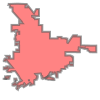

In [96]:
shape_count = 0
for m in raw_municipal_data['features']:
    if m['properties']['Name'] == 'GAINESVILLE':
        new_shape = shape(m['geometry'])
        if (shape_count == 0):
            gainesville_shape = new_shape
        else:
            gainesville_shape = gainesville_shape.union(new_shape)
        shape_count += 1

print "Collected municipal boundaries from ", shape_count, " shapes"
gainesville_shape

*** Trim tract shapes to fit Gainesville's boundaries ***

(29.5928305172926, 29.7783563820721)

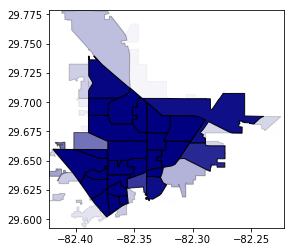

In [97]:
tract_shapes = {}

for feature in raw_tracts_data['features']:
    if feature['type'] != 'Feature':
        continue

    properties = feature['properties']
    if properties['COUNTYFP'] != '001':
        continue

    geometry = feature['geometry']
    old_shape = shape(geometry)
    new_shape = old_shape.intersection(gainesville_shape)
    if not new_shape.is_empty:
        # Format tract ID
        id_parts = properties['NAME'].split('.') # TODO: don't split, use GEOID as identifier instead
        tract_id = id_parts[0]
        tract_id += id_parts[1].ljust(2, '0') if (len(id_parts) == 2) else '00'
        tract_geoid = properties['GEOID']

        tract = {}
        tract['GEOID'] = tract_geoid
        tract['Name'] = tract_id
        tract['Shape'] = new_shape
        tract['Fraction'] = new_shape.area / old_shape.area
        tract_shapes[tract_id] = tract

# Draw our new tract shapes
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

bounds = [dglim.City.longitude, dglim.City.latitude, dglim.City.longitude, dglim.City.latitude]
for tract_id in tract_shapes:
    tract = tract_shapes[tract_id]
    
    polygon = tract['Shape']
    patch = PolygonPatch(polygon, facecolor=[0,0,0.5], edgecolor=[0,0,0], alpha=tract['Fraction'], zorder=2)
    ax.add_patch(patch)

    bounds[0] = min(bounds[0], polygon.bounds[0])
    bounds[1] = min(bounds[1], polygon.bounds[1])
    bounds[2] = max(bounds[2], polygon.bounds[2])
    bounds[3] = max(bounds[3], polygon.bounds[3])

plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])

In [98]:
bounds

[-82.4223898406203, 29.5928305172926, -82.2223916783364, 29.7783563820721]

*** Save shapes as files ***

In [99]:
# Municipal boundaries
f = open("../Geometries/gainesville_shape", "w")
f.write(dumps(gainesville_shape))
f.close()

# Tracts

## Raw data
f = open("../Geometries/tract_shapes", "w")
for tract_id in tract_shapes:
    tract = tract_shapes[tract_id]
    f.write(tract['GEOID'] + '\n')
    f.write(tract['Name'] + '\n')
    f.write(str(tract['Fraction']) + '\n')
    f.write(dumps(tract['Shape']) + '\n')
f.close()

In [101]:
## Geojson
json_features = []
for tract_id in tract_shapes:
    tract_shape = tract_shapes[tract_id]
    polygon = tract_shape['Shape']
    json_polygon = mapping(polygon)

    json_features.append({
        "type": "Feature",
        "properties": {
            "GEOID": tract_shape['GEOID'],
            "COUNTYFP": "001",
            "NAME": tract_shape['Name'],
            "FRACTION": tract_shape['Fraction'],
            "ALAND": polygon.area * 10575003490, # Approximate conversion to whatever units Census uses
        },
        "geometry": json_polygon
    })

json_data = {
    "type": "FeatureCollection",
    "features": json_features
}

'{"type": "FeatureCollection", "features": [{"geometry": {"type": "Polygon", "coordinates": [[[-82.311469, 29.651985], [-82.306576, 29.659338], [-82.30183, 29.666511], [-82.302225, 29.665245], [-82.289147, 29.665342], [-82.288995, 29.663594], [-82.288493, 29.663137], [-82.285657, 29.662795], [-82.274021, 29.66276], [-82.27248, 29.662756], [-82.27247826331853, 29.661504373661177], [-82.2724845458142, 29.6591253965752], [-82.27247170971143, 29.65678118902732], [-82.27247, 29.655549], [-82.27246454935172, 29.65547352037066], [-82.272445525244, 29.6519992215318], [-82.2725999933643, 29.651999526484], [-82.2726037129511, 29.6517219586332], [-82.2749655101586, 29.6517264719377], [-82.2765705469201, 29.6517295214677], [-82.2775149008626, 29.6517330589223], [-82.2789628026303, 29.6517337298189], [-82.2791515892017, 29.6517337908095], [-82.2791517997444, 29.6516650543847], [-82.2791693449647, 29.648302645378], [-82.2783508955239, 29.6482992297882], [-82.2783507551621, 29.6483267374817], [-82.27

## Get Distance to Nearest Bus Stop

*** Get Bus Stop Data ***

In [24]:
stops_df = pd.read_csv('../City_Data/RTS Data/stops.csv')
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url
0,1,1,Rosa Parks Downtown Station,Northbound SE 3rd ST @ Nearside SE 3rd ST,29.645567,-82.322697,NaN,
1,2,2,Hampton Inn Hotel,Westbound SE 2nd AVE @ Nearside SE 1st ST,29.650346,-82.323804,NaN,NaN
2,3,3,Westbound SW 2nd Avenue @ SW 2nd Street,Westbound SW 2nd AVE @ Nearside SW 2nd ST,29.650397,-82.326459,NaN,
3,4,4,The Continuum,Westbound SW 2nd AVE @ Nearside SW 6th ST,29.650325,-82.329674,NaN,
4,6,6,Ayers Medical Plaza,Westbound SW 2nd AVE @ Nearside SW 8th ST,29.650335,-82.332790,NaN,


### Find Distance to Closest Stop for each Business

*** Define some helper functions ***

In [25]:
def findNearestBusStop(business_location):
    l = 0
    r = len(stops_df)-1
    closest_distance = np.inf;
    closest_stop = -1;
    for i in range(0, r):
        stop_location = (float(stops_df['stop_lat'][i]), float(stops_df['stop_lon'][i]))
        distance = vincenty(business_location, stop_location)
        if distance < closest_distance:
            closest_distance = distance;
            closest_stop = i;
    return (closest_stop, closest_distance)

*** Perform search ***

In [26]:
# Let's print a dot every 2% of the job
two_percent = len(master_df)/50

# Set this to limit the number of iterations performed (set to -1 for no limit)
sample_size = -1;

print "Beginning search"

# Sample progress bar to gauge actual progress
print "[",
for i in range(0, 50):
    print ".",
print "]"

# Find the distance between each business and the closest bus stop
distancesDict = {}

print "[",
for i, act_bus in master_df.iterrows():
    bus_loc = (float(act_bus['Latitude']), float(act_bus['Longitude']))
    if not (np.isnan(bus_loc[0]) or np.isnan(bus_loc[1])):
        closest = findNearestBusStop(bus_loc)
        distancesDict[act_bus['DGLIM ID']] = closest;

    # Show a progress bar
    if (i != 0 and i % two_percent == 0):
        print ".",
    if (i == sample_size):
        break;
print "]"
print "Done!"

Beginning search
[ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ]
[ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ]
Done!


In [27]:
# Create dataset from results
closest_stop_df = pd.DataFrame()
closest_stop_df['DGLIM ID'] = master_df['DGLIM ID']
closest_stop_df['Distance to Bus Stop'] = closest_stop_df['DGLIM ID'].apply(lambda x : distancesDict[x][1].meters if x in distancesDict else np.nan)

closest_stop_df.head()

,DGLIM ID,Distance to Bus Stop
DGLIM ID,,
16,16,110.521226
17,17,20.692666
24,24,209.539654
25,25,87.251811
38,38,60.741727


In [28]:
distancesDict[1][1].meters

139.83039632871228

## Write Results to CSV File

In [29]:
dglim.saveData(closest_stop_df, 'Bus Stop Distances')

In [10]:
new_bus_df = pd.read_csv("../City_Data/Active_Businesses_2018.csv")

In [19]:
new_bus_df['Start Date'].apply(lambda x: x.split('/')[2] if type(x) is str else x).sort_values()

1712    1948
116     1955
1976    1957
1271    1958
1238    1958
5694    1968
4270    1968
6509    1969
3138    1969
1090    1971
2223    1971
4119    1972
5081    1972
5351    1973
216     1973
22      1973
6458    1974
5047    1975
1097    1975
4798    1975
6340    1975
2931    1975
3818    1976
3666    1976
5537    1976
3933    1976
2159    1977
5700    1977
3929    1977
2202    1977
        ... 
4263    2018
1233    2018
2752    2018
6234    2018
339     2018
1179    2018
6231    2018
6230    2018
2710    2018
6223    2018
6222    2018
6220    2018
2716    2018
2718    2018
2720    2018
2128    2018
2727    2018
2728    2018
1199    2018
1200    2018
1201    2018
2737    2018
6198    2018
1229    2018
2749    2018
2751    2018
2753    2018
5738    2018
1606     NaN
5922     NaN
Name: Start Date, Length: 6566, dtype: object

In [27]:
len(new_bus_df['Email'].dropna().unique())

4225

In [24]:
len(new_bus_df['ID'].unique())

5470

In [28]:
len(new_bus_df['Name'].unique())

5231

In [61]:
missing_ids = set(act_bus_df['ID'].tolist()) - set(new_bus_df['ID'].tolist())
len(missing_ids)

574

In [62]:
new_ids = set(new_bus_df['ID'].tolist()) - set(act_bus_df['ID'].tolist())
len(new_ids)

516

In [67]:
act_bus_df.set_index('ID').loc[missing_ids]

,Business Type,Name,Start Date,Physical Address,Mailing Address,Mailing City,Business Phone,Email,Contact,Location,uniqueid
ID,,,,,,,,,,,
14338,ATTORNEY/LAWYER,"GARVIN, DEBORAH R., ATTORNEY",1991-11-01,4127 NW 27TH LN,P.O. BOX 358041,"GAINESVILLE,FL 32635",352-373-2598,debbie.garvin@warrington.ufl.edu,DEBORAH GARVIN,"4127 NW 27TH LN\nGAINESVILLE, FL\n(29.677982, ...",6458
40965,CONTRACTOR-PAINTER/PAPERHANGER,"LYNETTA NORMAN CLEANING, PAINTING",2014-06-02,4118 NW 6TH ST,4118 NW 6TH ST,"GAINESVILLE,FL 32609",352-281-6493,IMAGECLOTHINGBOUTIQUE@GMAIL.COM,"LYNETTA NORMAN CLEANING, PAINTING & CARPET SVC...","4118 NW 6TH ST\nGAINESVILLE, FL\n(29.690705, -...",4510
40965,INTERIOR JANITORIAL AND CLEANING SERVICES,"LYNETTA NORMAN CLEANING, PAINTING",2014-06-02,4118 NW 6TH ST,4118 NW 6TH ST,"GAINESVILLE,FL 32609",352-281-6493,IMAGECLOTHINGBOUTIQUE@GMAIL.COM,"LYNETTA NORMAN CLEANING, PAINTING & CARPET SVC...","4118 NW 6TH ST\nGAINESVILLE, FL\n(29.690705, -...",4544
40967,RETAIL BAKERY - PLANT ON PREMISES,"DAIN, BEATRICE K",2014-05-01,2260 NW 11TH AVE,2260 NW 11TH AVE,"GAINESVILLE,FL 32605",352-519-6629,beasweetbakery@gmail.com,BEATRICE DAIN,"2260 NW 11TH AVE\nGAINESVILLE, FL\n(29.662449,...",5455
28683,AUTO REPAIR GARAGE,J.P. ENTERPRISES,2002-11-15,2014 NE 23RD AVE,PO BOX 98,"ALACHUA,FL 32616",352-538-5484,JPENTERPRISE41@AOL.COM,JERRY PEPPEL,"2014 NE 23RD AVE\nGAINESVILLE, FL\n(29.673787,...",2520
40990,HOLIDAY OR SEASONAL LOT SALES,KABOOM FIREWORKS LLC,2014-06-25,5432 NW 8TH AVE,PO BOX 358840,"GAINESVILLE,FL 32635",352-562-2666,kaboomfireworksllc@gmail.com,CORP KABOOM FIREWORKS LLC,"5432 NW 8TH AVE\nGAINESVILLE, FL\n(29.659601, ...",2624
20511,REAL ESTATE BROKER,"SUSKIN, LESLIE B. (R/E)",1982-09-01,"3131 NW 13TH ST, SUITE 6","3131 NW 13TH ST, SUITE 6","GAINESVILLE,FL 32609",352-373-7513,office@suskinrealty.com,LESLIE SUSKIN,"3131 NW 13TH ST\nGAINESVILLE, FL\n(29.681687, ...",1979
24616,CHIROPRACTOR,PEMBROKE COMMONS CHIROPRACTIC,1998-09-01,"1330 NW 6TH ST, SUITE C",3021 NW 10TH PL,"GAINESVILLE,FL 32605",352-336-6767,DRALIGN@YAHOO.COM,"PEMBROKE COMMONS CHIROPRACTIC CENTER, PA","1330 NW 6TH ST\nSUITE C GAINESVILLE, FL\n(29.6...",1457
32812,"STENOGRAPHER, TYPIST, COURT REPORTER","MONSON, JACQUELINE",2005-09-01,305 NE 1ST ST,232 TURKEY CREEK,"ALACHUA,FL 32615",386-418-4222,JMONSON@WINDSTREAM.NET,JACQUELINE MONSON,"305 NE 1ST ST\nGAINESVILLE, FL\n(29.65416, -82...",2414


In [33]:
new_bus_df['ID']

0       35905
1       28286
2       40028
3       13684
4       30144
5       12219
6       43063
7       40121
8       38866
9       39587
10      39587
11      13683
12      25195
13      12532
14      42489
15      42211
16      38111
17      39410
18      39587
19      18979
20      42819
21      39981
22      12618
23      41125
24      39587
25      32626
26      38703
27      40121
28      24900
29      37060
        ...  
6536    32048
6537    13212
6538    35206
6539    19443
6540    32084
6541    41879
6542    42465
6543    25917
6544    26563
6545    39006
6546    40205
6547    33185
6548    41630
6549    38643
6550    42296
6551    39941
6552    35036
6553    42529
6554    11491
6555    41624
6556    28670
6557    11371
6558    37042
6559    41879
6560    42296
6561    42810
6562    28144
6563    33561
6564    42255
6565    39067
Name: ID, Length: 6566, dtype: int64

In [20]:
act_bus_df['Start Date'].apply(lambda x: x.split('/')[2] if type(x) is str else x).sort_values()

4067   1948-01-12
1727   1955-10-01
3384   1957-01-01
1217   1958-03-01
1230   1958-03-01
2162   1968-03-01
2577   1968-03-01
3079   1969-03-01
4800   1969-09-01
35     1971-01-01
5703   1971-01-01
1188   1971-12-13
1615   1972-01-01
469    1972-10-01
4571   1973-01-01
5445   1973-01-01
3109   1973-01-01
4013   1974-12-17
6768   1975-01-01
3313   1975-01-01
2339   1975-01-01
1174   1975-01-01
3242   1975-01-01
6669   1975-10-01
3526   1976-06-01
3882   1976-09-01
335    1976-11-01
2888   1976-11-01
3415   1977-01-01
1409   1977-01-01
          ...    
4229   2017-07-20
4647   2017-07-21
4678   2017-07-21
5551   2017-07-21
4294   2017-07-24
6655   2017-07-25
4908   2017-07-27
4896   2017-07-27
4726   2017-07-28
4953   2017-07-31
4448   2017-08-01
5005   2017-08-01
4496   2017-08-01
6671   2017-08-01
6086   2017-08-01
4716   2017-08-01
4449   2017-08-03
6074   2017-08-04
4714   2017-08-04
6090   2017-08-07
6268   2017-08-08
6567   2017-08-11
6643   2017-08-14
6065   2017-08-14
6612   201

In [23]:
act_bus_df.iloc[4067]

Business Type           INSURANCE COMPANY OR BROKER
ID                                            22146
Name                PENNSYLVANIA LIFE INSURANCE CO.
Start Date                      1948-01-12 00:00:00
Physical Address                       OUT OF STATE
Mailing Address              ONE CVS DRIVE, MC 2240
Mailing City                    WOONSOCKET,RI 02895
Business Phone                         401-770-5407
Email                  WSMITH@UNIVERSALAMERICAN.COM
Contact             PENNSYLVANIA LIFE INSURANCE CO.
Location             OUT OF STATE GAINESVILLE, FL\n
uniqueid                                       4068
Name: 4067, dtype: object

In [29]:
x = 5

In [74]:
dglim.loadData('Crimes Within 500m by DGLIM ID')

,2011,2012,2013,2014,2015,2016,2017
DGLIM ID,,,,,,,
16,79,84,79,65,32,48,64
17,675,625,596,543,337,532,564
24,63,71,73,80,31,49,44
